In [1]:
import nibabel as nib
import os
import torch
from utils import viewer_3d,show_mv,plt_images,complex_pyramid,complex_NLL,complex_total_variation
import torchvision.transforms.functional as F1
from torchvision.transforms import v2
import torch.nn.functional as F
import torchfields
from complexPyTorch.complexFunctions import complex_upsample, complex_upsample2
import kornia as K
from tqdm import tqdm

/Users/pi58/opt/anaconda3/envs/mri_recon/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/pi58/opt/anaconda3/envs/mri_recon/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Pl

In [5]:
from matplotlib import pyplot as plt
def plt_images(slices_list, z,title):
  """

  :param slices_list: Ex : [10,11,12,13,14,15]
  :param z: The list that contains all tensors. Ex : To plot (img+,img-) -> z = [img_pos,img_inv]
  :return:
  """

  # minmin = torch.min(torch.min(z[0]), torch.min(z[-1]))
  # maxmax = torch.max(torch.max(z[0]), torch.max(z[-1]))
  slices = slices_list
  i = 0
  rows = len(z)
  cols = len(slices)
  f, ax = plt.subplots(rows, cols)
  f.set_figheight(8)
  f.set_figwidth(16)
  f.suptitle(title,fontsize=18)


  for r in range(rows):
    for c in range(cols):
      temp = z[r]
      slice_num = slices[i]
      temp = ax[r, c].imshow(temp[slice_num,], cmap='gray')
      ax[r, c].set_title("Slice = " + str(slice_num))
      ax[r, c].axis('off')

      cbar = f.colorbar(temp,ticklocation="bottom")
      cbar.ax.tick_params(labelsize=7)
      # cbar.set_ticks(ticks=[minmin,maxmax], labels = [float("{:.f}".format(minmin)),float("{:.4f}".format(maxmax))])

      i += 1
    i = 0
  plt.show()

In [6]:
file1 = '/Users/pi58/Library/CloudStorage/Box-Box/PhD/Datasets/ExBox20/nodif.nii.gz'
file2 = '/Users/pi58/Library/CloudStorage/Box-Box/PhD/Datasets/ExBox20/nodif_PA.nii.gz'
img1 = nib.load(file1)
img2 = nib.load(file2)
print(img1.shape,img2.shape)

(116, 116, 76) (116, 116, 76)


In [7]:
img1  = torch.from_numpy(img1.get_fdata())
img2  = torch.from_numpy(img2.get_fdata())
img1 = torch.permute(img1,(2,0,1))
img2 = torch.permute(img2,(2,0,1))
print(img1.shape,img2.shape)

torch.Size([76, 116, 116]) torch.Size([76, 116, 116])


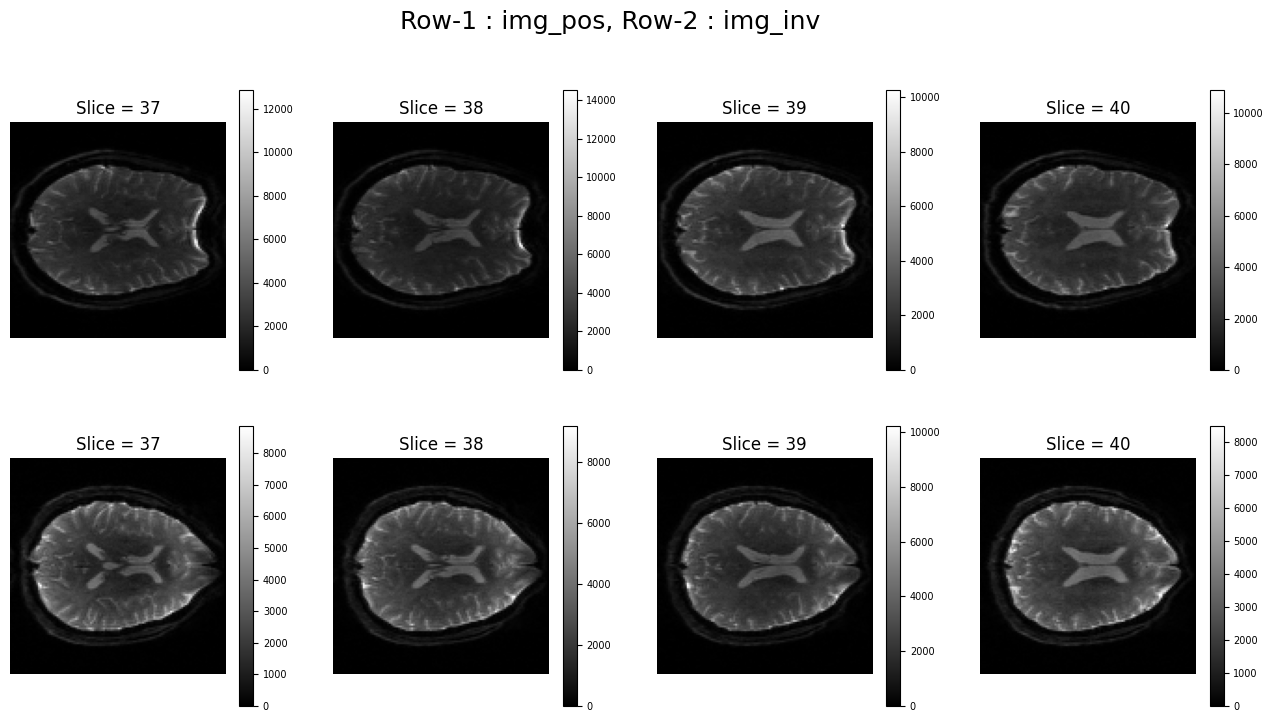

In [8]:
slices = [37,38,39,40]
z = [img1,img2]
plt_images(slices,z,"Row-1 : img_pos, Row-2 : img_inv")

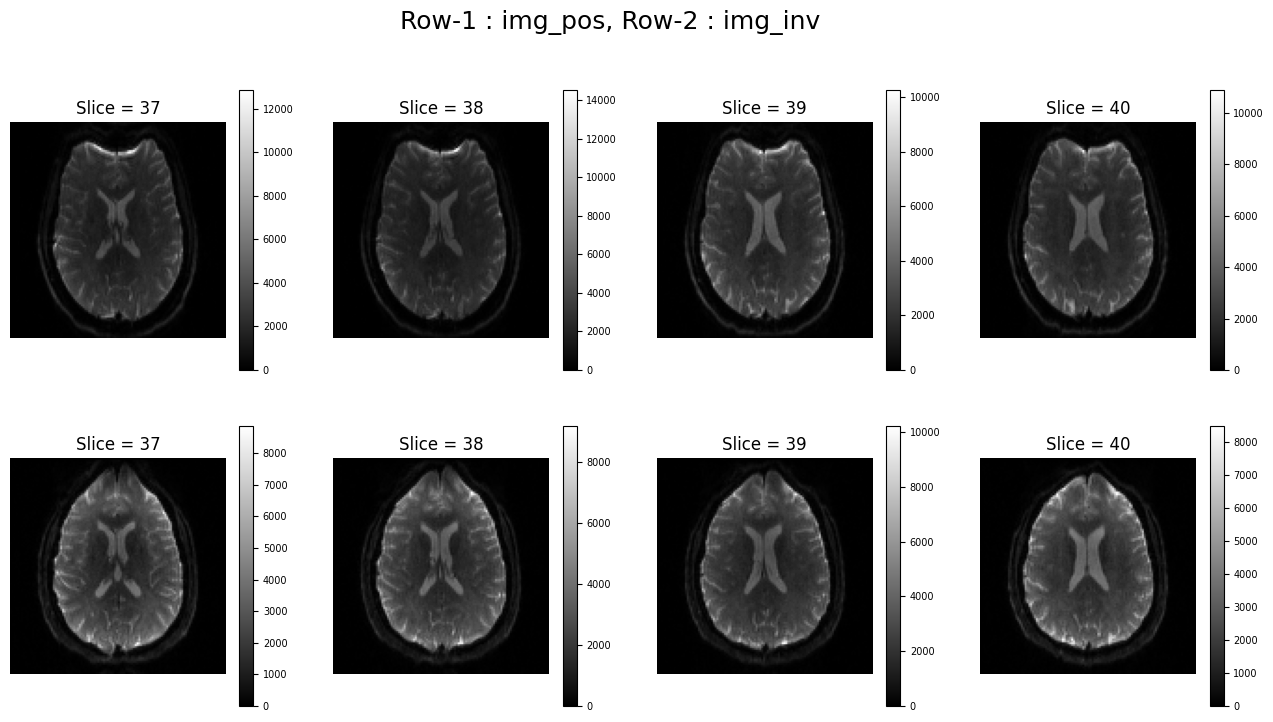

In [10]:
rotated1 = torch.rot90(img1, 1,[1,2])
rotated2 = torch.rot90(img2, 1,[1,2])
z = [rotated1,rotated2]
plt_images(slices,z,"Row-1 : img_pos, Row-2 : img_inv")

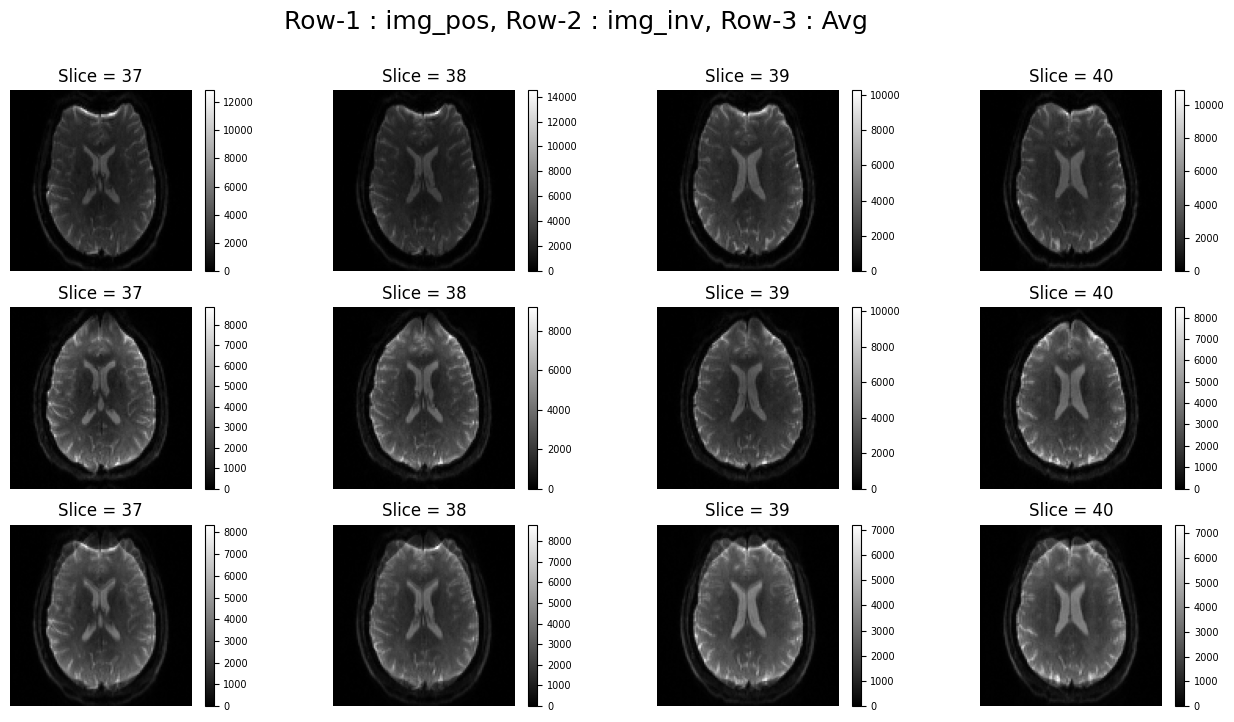

In [11]:
avg = (rotated1+rotated2)/2
z = z = [rotated1,rotated2,avg]
plt_images(slices,z,"Row-1 : img_pos, Row-2 : img_inv, Row-3 : Avg")

In [12]:
img_pos = rotated1
img_inv = rotated2
f_pos = torch.fft.fftn(img_pos) #Converting to k-space
f_inv = torch.fft.fftn(img_inv)

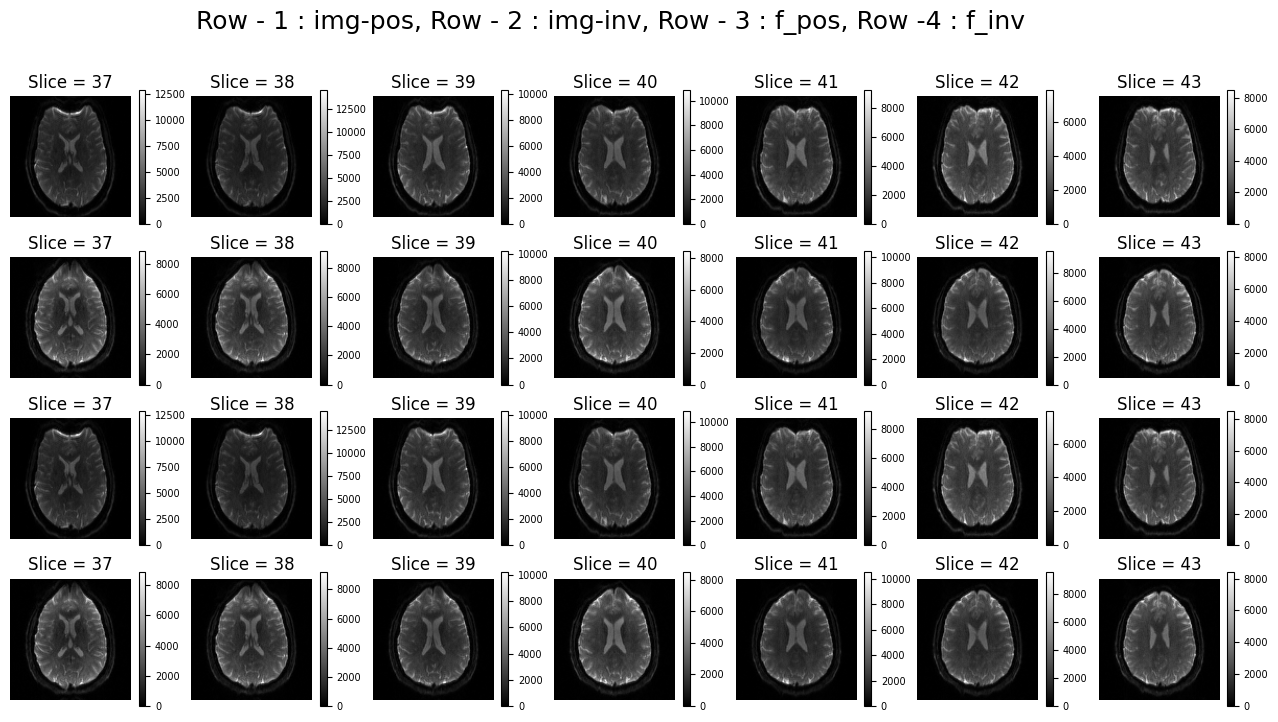

In [13]:
slices = [37,38,39,40,41,42,43]
z = [img_pos,img_inv,torch.abs(torch.fft.ifftn(f_pos)),torch.abs(torch.fft.ifftn(f_inv))]
plt_images(slices,z,"Row - 1 : img-pos, Row - 2 : img-inv, Row - 3 : f_pos, Row -4 : f_inv")

In [14]:
def get_gaussian_kernel1d(kernel_size, sigma):
    ksize_half = (kernel_size - 1) * 0.5

    x = torch.linspace(-ksize_half, ksize_half, steps=kernel_size)
    pdf = torch.exp(-0.5 * (x / sigma).pow(2))
    # print(torch.sum(pdf))
    kernel1d = pdf / pdf.sum()
    return kernel1d


def get_gaussian_kernel2d(kernel_size, sigma, device='cpu'):
    kernel1d_x = get_gaussian_kernel1d(kernel_size[0], sigma[0]).to(device)
    kernel1d_y = get_gaussian_kernel1d(kernel_size[1], sigma[1]).to(device)
    
    kernel2d = torch.mm(kernel1d_y[:, None], kernel1d_x[None, :])
    
    return kernel2d

In [15]:
import numpy as np
def complex_gaussian_blur(complex_3dtensor,sigma=(0.2,0.2)):
    #Gaussian Filtering in Frequency domain
    complex_3dtensor = complex_3dtensor.reshape(complex_3dtensor.shape[-3], complex_3dtensor.shape[-2], complex_3dtensor.shape[-1])
    smoothened = []
    kernel_size = (complex_3dtensor.shape[-2],complex_3dtensor.shape[-1])
    gaussian_kernel = get_gaussian_kernel2d(kernel_size,sigma)
    gaussian_kernel = torch.fft.fftn(torch.fft.fftshift(gaussian_kernel))
    
    for i in range(len(complex_3dtensor)):
        # temp = f_pos[i,] * gaussian_kernel
        temp = torch.mul(complex_3dtensor[i,],gaussian_kernel)
        # print(temp.shape)
        temp = temp.reshape(1,kernel_size[0],kernel_size[1])
        smoothened.append(temp)
    
    
    smoothened = torch.cat(smoothened,dim=0) #Note that the kspace data here is shifted. Need to inverse shift
    # z1 = torch.fft.ifftn(smoothened)
    
    return smoothened

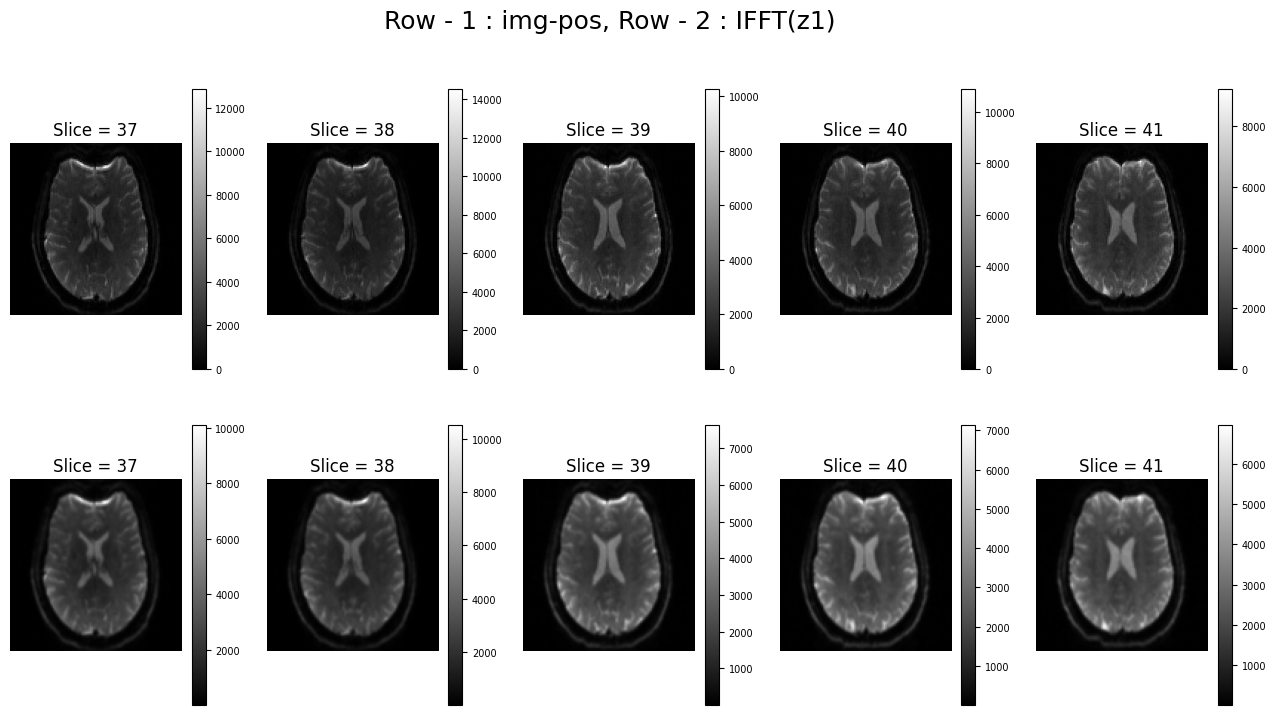

In [16]:
z1 = complex_gaussian_blur(f_pos,sigma=(0.7,0.7))

slices = [37,38,39,40,41]
z = [img_pos,torch.abs(torch.fft.ifftn(z1))]
plt_images(slices,z,"Row - 1 : img-pos, Row - 2 : IFFT(z1)")

In [24]:
z1.shape

torch.Size([76, 116, 116])

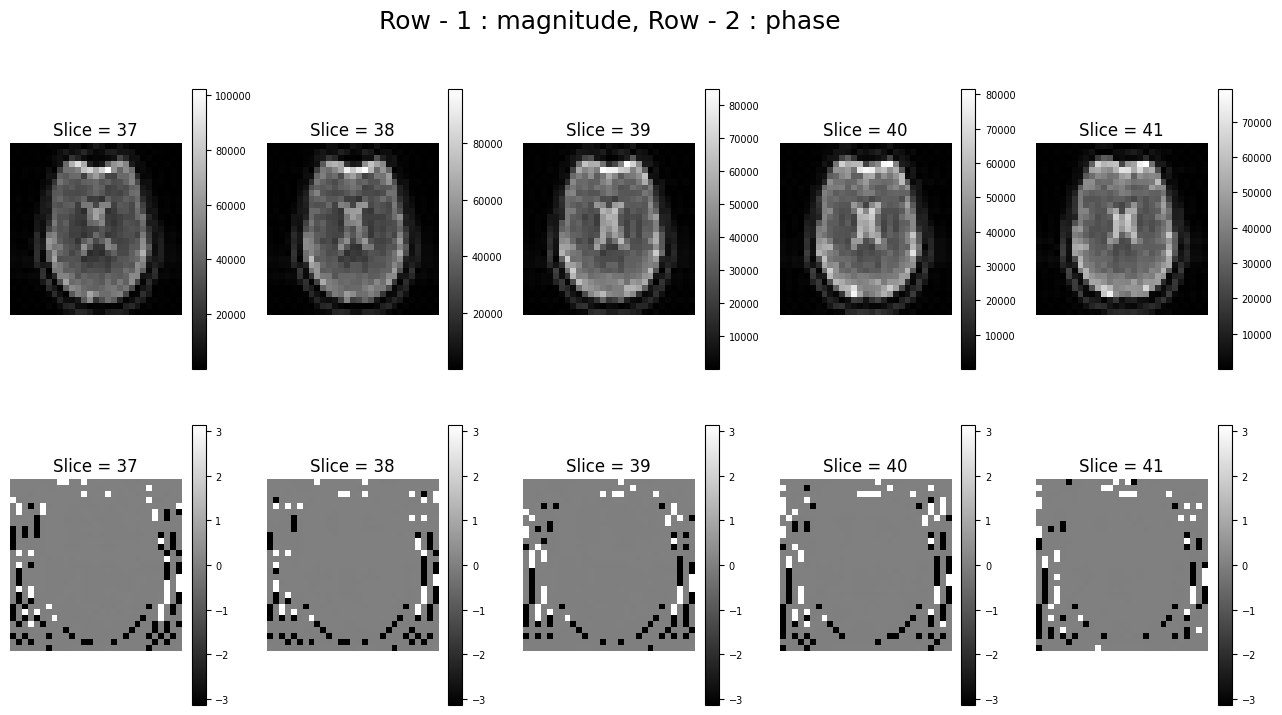

In [17]:
transform = v2.CenterCrop((29,29))
# z1 = torch.fft.fftshift(z1)
p1 = torch.fft.fftshift(z1)
f_pos_2 = transform(p1)
img_pos_2 = (torch.fft.ifftn(torch.fft.ifftshift(f_pos_2))) #should do shifting if using direct kspace data
img_pos_2 = img_pos_2.reshape(76,29,29)
# z2 = torch.fft.ifftn(z1).reshape(76,116,116)
# phase1 = (torch.atan2(torch.imag(img_pos),torch.real(img_pos)))
# phase2 = (torch.atan2(torch.imag(z2),torch.real(z2)))
phase2 = (torch.atan2(torch.imag(img_pos_2),torch.real(img_pos_2)))

z = [img_pos_2.abs(),phase2]
plt_images(slices,z,"Row - 1 : magnitude, Row - 2 : phase")

In [60]:
img_pos_2.shape

torch.Size([76, 58, 58])

In [18]:
def kspace_pyramid(complex_3dtensor, levels = 3):
    tensor = complex_gaussian_blur(complex_3dtensor,(0.1,0.1)) #kspace
    tensor = complex_3dtensor
    tensor = torch.fft.fftshift(tensor)
    temp = tensor
    pyramid = []
    (slices, height, width) = (temp.shape[-3],temp.shape[-2],temp.shape[-1])
    for i in range(levels):
        # temp = complex_upsample(temp.reshape(1,slices,height,width),size = (int(height/2), int(width/2)))
        transform = v2.CenterCrop((height,width))
        temp = transform(tensor)
        temp = temp.reshape(1,temp.shape[-3],temp.shape[-2],temp.shape[-1])
        pyramid.append(temp)
        (slices, height, width) = (slices, int(height/2), int(width/2))
    return pyramid

z = kspace_pyramid(f_pos)
print(z[0].shape,z[1].shape,z[2].shape)

torch.Size([1, 76, 116, 116]) torch.Size([1, 76, 58, 58]) torch.Size([1, 76, 29, 29])


torch.Size([76, 29, 29])


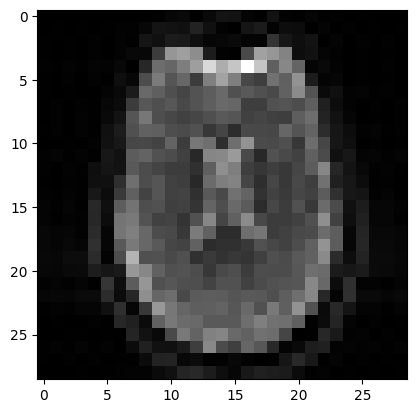

In [20]:
h = 29
ift0 = torch.fft.ifftn(torch.fft.ifftshift(z[-1])).reshape(76,h,h).abs()
print(ift0.shape)
plt.imshow(ift0[38],cmap='gray')

In [21]:
w = torch.Field.identity(1,2,29,29,requires_grad=True)

template_image_list = []
w_list = []
losses = []

In [22]:
f_pos = f_pos.reshape(1,f_pos.shape[-3],f_pos.shape[-1],f_pos.shape[-1])
f_inv = f_inv.reshape(1,f_pos.shape[-3],f_pos.shape[-1],f_pos.shape[-1]) #Is this needed????????

f_pos_pyramid = kspace_pyramid(f_pos)
f_inv_pyramid = kspace_pyramid(f_inv)

In [301]:
f_pos_pyramid[0].shape

torch.Size([1, 76, 116, 116])

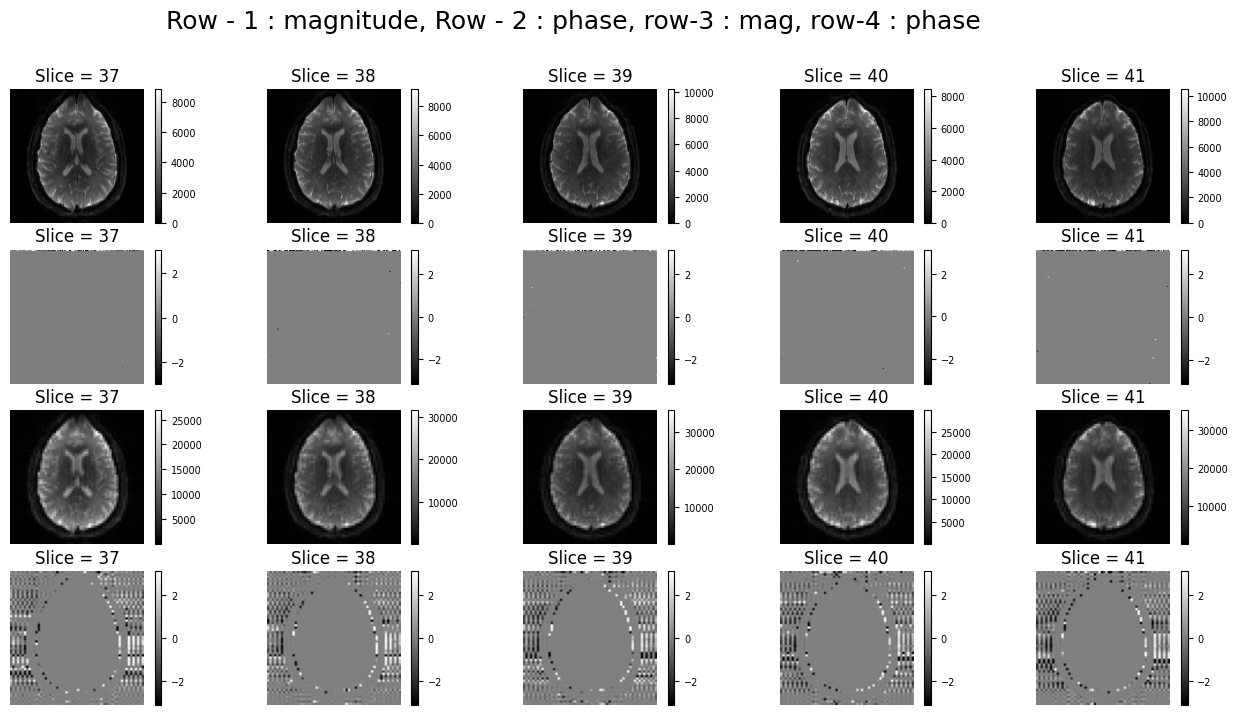

In [23]:
h0 = 116
h1 = 58
iz0 = (torch.fft.ifftn(torch.fft.ifftshift(f_inv_pyramid[0]))).reshape(76,h0,h0) #should do shifting if using direct kspace data
iz1 = (torch.fft.ifftn(torch.fft.ifftshift(f_inv_pyramid[1]))).reshape(76,h1,h1) #should do shifting if using direct kspace data

phase0 = (torch.atan2(torch.imag(iz0),torch.real(iz0)))
phase1 = (torch.atan2(torch.imag(iz1),torch.real(iz1)))

z = [iz0.abs(),phase0, iz1.abs(),phase1]
plt_images(slices,z,"Row - 1 : magnitude, Row - 2 : phase, row-3 : mag, row-4 : phase")

In [24]:
#Template Image Initialization
t1 = torch.fft.ifftn(torch.fft.ifftshift(f_pos_pyramid[-1]))
t2 = torch.fft.ifftn(torch.fft.ifftshift(f_inv_pyramid[-1]))
                     
template_img = torch.tensor((t1+t2)/2,requires_grad=True)
# template_img = blurrer(template_img)
w = torch.Field.identity(1,2,29,29,requires_grad=True)
avg = template_img.clone().detach()

/var/folders/jn/htj79lg12cg80r08kmc0y55h00z9nl/T/ipykernel_58759/705634795.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  template_img = torch.tensor((t1+t2)/2,requires_grad=True)


In [25]:
def forward_model_multi_resolution(w,template_img):
    #W = Transformation matrix (Deformation matrix) (Warping matrix) (theta)
    # ratio = brightness_factor
    img = template_img.reshape(1,template_img.shape[-3],template_img.shape[-1],template_img.shape[-1])
    
    
    img1_real = w(img.real.float()) #Warping
    img1_imag = w(img.imag.float()) #Warping
    img1 = img1_real + 1j * img1_imag
    
    # img2 = torch.zeros_like(img1)
    # img = F1.adjust_brightness(img.reshape(-1,1,template_img.shape[-1],template_img.shape[-1]),brightness_factor).reshape(1,35,template_img.shape[-1],template_img.shape[-1])
    # img = (ratio * img1 + (1.0 - ratio) * img2).clamp(0, 1).to(img1.dtype)  #Adjusting Brightness Factor
    #ift = torch.matmul(K,img())
    img = torch.fft.fftn(img1)
    return img

In [29]:
tv_loss = K.losses.TotalVariation()
def optimize_multi_res(epochs, learning_rate, w, template_img_real,template_img_imag, f_pos_pyramid, f_inv_pyramid):
    template_image_list = []
    w_list = []
    # losses_list_1, losses_list_2, losses_list_3, losses_list_4 = [],[],[],[]
    # losses_list = [losses_list_1,losses_list_2,losses_list_3,losses_list_4]
    
    loss = torch.nn.GaussianNLLLoss()
    total_variation = K.losses.TotalVariation()
    # print(template_img.shape,template_img.is_leaf)
       
    for i in reversed(range(3)):
        
        # Initialize optimizer
        # tv_denoiser = TVDenoise(template_img)

        optimizer = torch.optim.LBFGS([w, template_img_real,template_img_imag], lr=learning_rate, max_iter=50)
        for t in tqdm(range(epochs)):
            template_img = torch.complex(template_img_real, template_img_imag)
            def closure():
                optimizer.zero_grad()
                # print(torch.complex(template_img_real,template_img_imag).shape,w.shape,f_pos_pyramid[i].shape)
                prediction1 = forward_model_multi_resolution(w, torch.complex(template_img_real,template_img_imag))  # 1
                prediction2 = forward_model_multi_resolution(-w, torch.complex(template_img_real,template_img_imag)) #1
                print(prediction1.shape)
                
    
    
                # z1 = template_img.reshape(template_img.shape[-3],template_img.shape[-2],template_img.shape[-1]).detach()
                # z = [z1,avg2,img_pos.reshape(template_img.shape[-3],img_pos.shape[-2],img_pos.shape[-1]),img_inv.reshape(35,img_pos.shape[-1],img_pos.shape[-1])]
                # # plt.clf()
                # slices = [37,38,39,40]
                # z1 = torch.fft.ifftn(torch.fft.ifftshift(prediction1)).reshape(76,prediction1.shape[-2],prediction1.shape[-1]).detach()
                # z2 = torch.fft.ifftn(torch.fft.ifftshift(prediction2)).reshape(76,prediction2.shape[-2],prediction2.shape[-1]).detach()
                # z = [z1.abs(), z2.abs()]
                # plt_images(slices,z,"Row - 1 : Optimized template, Row-2 : Initial template, Row-3 : img_pos, Row-4 : img_inv ")
            
                # print(prediction1.shape,prediction2.shape,f_pos_pyramid[i].shape)  
                l1 = complex_NLL(f_pos_pyramid[i], prediction1)  # 2.1
                l2 = complex_NLL(f_inv_pyramid[i], prediction2)  # 2.2
                # print(l1.shape)
                
                # l3 = complex_total_variation(prediction1) + complex_total_variation(prediction2)
                l3 = tv_loss(w).tensor().mean()
                
                # print(l3)
                NLL = l1 + l2 + (1e-2 * l3)
    
                # losses.append(NLL.item())  # To plot the loss graph
                list_dict[i].append(NLL.item())
                NLL.backward(retain_graph=True)
               
                return NLL
    
            optimizer.step(closure)
            template_image_list.append(template_img)
            w_list.append(w)
        
            # loss_list.append(losses)
    
        if (i != 0):
            upsampler = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # template_img = upsampler(template_img)
            template_img_real = upsampler(template_img_real)
            template_img_imag = upsampler(template_img_imag)
            w = w.up()

        
        template_img_real.retain_grad()
        template_img_imag.retain_grad()
        w.retain_grad()
        # brightness_factor.retain_grad()
        # f1.retain_grad()
        # g.retain_grad()
    return template_image_list, w_list

In [30]:
w = torch.Field.identity(1,2,29,29,requires_grad=True)
t1 = t1.reshape(1,t1.shape[-3],t1.shape[-2],t1.shape[-1])
t2 = t2.reshape(1,t2.shape[-3],t2.shape[-2],t2.shape[-1])
template_img = torch.tensor((t1+t2)/2,requires_grad=True)


template_img_real = torch.tensor(template_img.real,requires_grad = True)
template_img_imag = torch.tensor(template_img.imag,requires_grad = True)
avg = template_img.clone().detach()

list_dict = {}
list_dict[0] = []
list_dict[1] = []
list_dict[2] = []
list_dict[3] = []



template_image_list, w_list  = optimize_multi_res(5,9e-3,w,template_img_real,template_img_imag,f_pos_pyramid,f_inv_pyramid)

/var/folders/jn/htj79lg12cg80r08kmc0y55h00z9nl/T/ipykernel_58759/376444930.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  template_img = torch.tensor((t1+t2)/2,requires_grad=True)
/var/folders/jn/htj79lg12cg80r08kmc0y55h00z9nl/T/ipykernel_58759/376444930.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  template_img_real = torch.tensor(template_img.real,requires_grad = True)
/var/folders/jn/htj79lg12cg80r08kmc0y55h00z9nl/T/ipykernel_58759/376444930.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  template_img_imag = torch.tensor

torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.43it/s]


torch.Size([1, 76, 29, 29])
torch.Size([])
torch.Size([])


 20%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 1/5 [00:00<00:00,  7.11it/s]

torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 58, 58])


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 3/5 [00:00<00:00,  9.28it/s]

torch.Size([])
torch.Size([])
torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 4/5 [00:00<00:00,  8.89it/s]

torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 58, 58])
torch.Size([])
torch.Size([])


  0%|                                                                                                                                                                                                                                                                                        | 0/5 [00:00<?, ?it/s]

torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])


 20%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                         | 1/5 [00:00<00:01,  2.51it/s]

torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 2/5 [00:00<00:01,  2.54it/s]

torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 3/5 [00:01<00:00,  2.85it/s]

torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 4/5 [00:01<00:00,  3.11it/s]

torch.Size([1, 76, 116, 116])
torch.Size([])
torch.Size([])
torch.Size([1, 76, 116, 116])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]

torch.Size([])
torch.Size([])


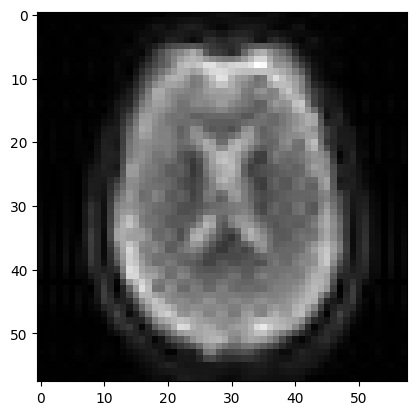

In [368]:
z = template_image_list[220].reshape(76,58,58).abs().detach()
plt.imshow(z[38],cmap='gray')

In [571]:
def phase(tensor):
    return torch.atan2(torch.imag(tensor),torch.real(tensor))

In [646]:
from matplotlib import pyplot as plt
def plt_images(slices_list, z,title_list,row_list,vmax_list):
    
    
    """
    
    :param slices_list: Ex : [10,11,12,13,14,15]
    :param z: The list that contains all tensors. Ex : To plot (img+,img-) -> z = [img_pos,img_inv]
    :return:
    """
    
    # minmin = torch.min(torch.min(z[0]), torch.min(z[-1]))
    # maxmax = torch.max(torch.max(z[0]), torch.max(z[-1]))
    slices = slices_list
    i = 0
    rows = len(z)
    cols = len(slices)
    f, ax = plt.subplots(rows, cols)
    f.set_figheight(16)
    f.set_figwidth(20)
    # f.suptitle(title,fontsize=18)
    # f.supylabel("fsdfsd")
    # f.set_ylabel("fdsfsd")
      
    for r in range(rows):
        for c in range(cols):
          temp = z[r]
          slice_num = slices[i]
          temp = ax[r, c].imshow(temp[slice_num,], cmap='gray',vmin=0,vmax =vmax_list[r])
          ax[r, c].set_title("Slice = " + str(slice_num),fontsize=7,loc='center')
          ax[r, c].tick_params(labelsize=5)
          # ax[r,:].set_ylabel("fsfdfsdfs")
            
          # ax[r, c].axis('off')
        
          cbar = f.colorbar(temp,ticklocation="bottom",shrink=0.5)
          cbar.ax.tick_params(labelsize=6)
          # cbar.set_ticks(ticks=[minmin,maxmax], labels = [float("{:.f}".format(minmin)),float("{:.4f}".format(maxmax))])
        
          i += 1
        i = 0

    # Label rows and columns
    # for ax, ve in zip(axs[0], [0.1, 1, 10]):
    #     ax.set_title(f'{ve}', size=18)
    for ax, v_title,h_title  in zip(ax[:, 0], title_list,row_list):
        ax.set_ylabel(v_title, size=9)
        ax.text(-25,-5,h_title, size=7,verticalalignment='center',horizontalalignment='center',rotation=0)
    
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()

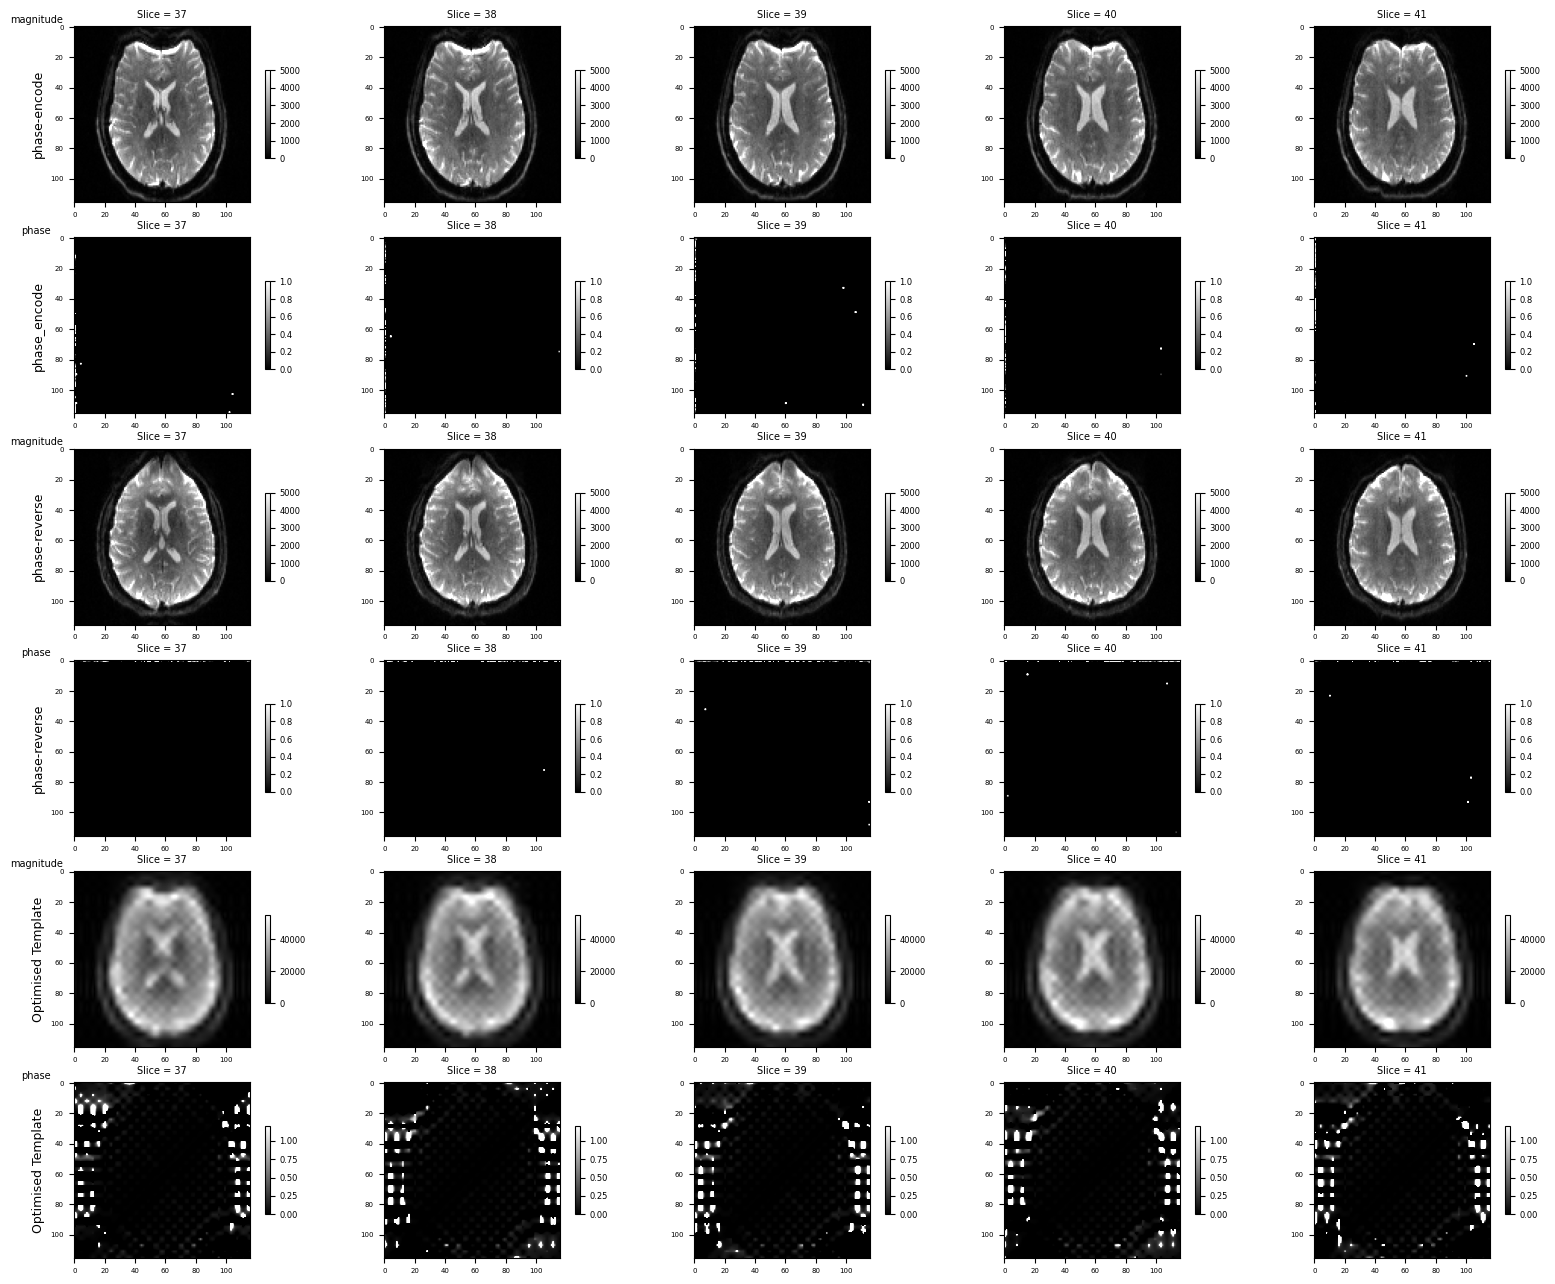

In [656]:
template_img = template_image_list[-1].reshape(76,116,116).detach()

mag = template_img.abs()
phase1 = (torch.atan2(torch.imag(template_img),torch.real(template_img)))

phase_encode = torch.fft.ifftn(f_pos).reshape(76,116,116)
phase_reverse = torch.fft.ifftn(f_inv).reshape(76,116,116)

vmax_list = [5000,1,5000,1,55000,1.2]
v_list = ["phase-encode","phase_encode","phase-reverse","phase-reverse","Optimised Template","Optimised Template","optimised template"]
h_list = ["magnitude","phase","magnitude","phase","magnitude","phase"]
z = [phase_encode.abs(),phase(phase_encode),phase_reverse.abs(),phase(phase_reverse),template_img.abs(),phase(template_img)]
plt_images(slices,z,v_list,h_list,vmax_list)

In [649]:
template_image_list[220].shape

torch.Size([1, 76, 58, 58])

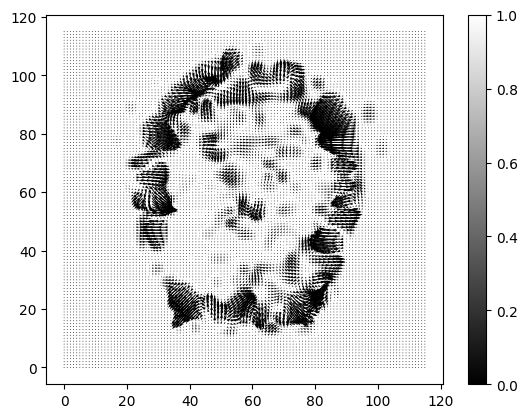

In [360]:
temp = w_list[-2].reshape(2,116,116).detach()
# cmap = plt.get_cmap("Oranges")
# colors = cmap([0.2,0.4,0.6,0.8])
# u,v = np.meshgrid(temp[0],temp[1])
dx = temp[0]
dy = temp[1]
q = plt.quiver(dx,dy,cmap='gray')
plt.colorbar(q)
plt.show()

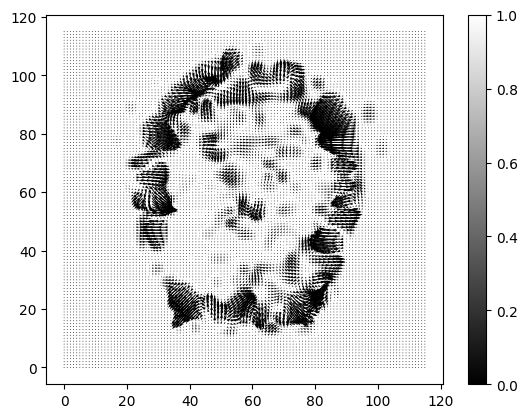

In [361]:
temp = w_list[-4].reshape(2,116,116).detach()
# cmap = plt.get_cmap("Oranges")
# colors = cmap([0.2,0.4,0.6,0.8])
# u,v = np.meshgrid(temp[0],temp[1])
dx = temp[0]
dy = temp[1]
q = plt.quiver(dx,dy,cmap='gray')
plt.colorbar(q)
plt.show()

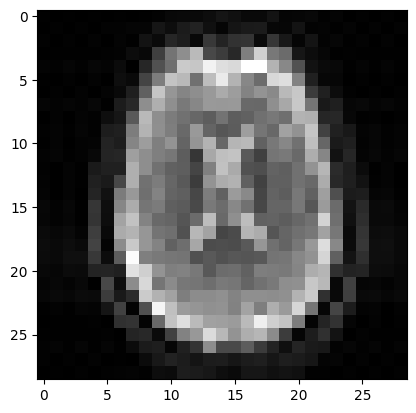

In [673]:
avg = avg.reshape(76,29,29).abs()
plt.imshow(avg[38],cmap='gray')

In [670]:
avg.shape

torch.Size([1, 76, 29, 29])